In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

### Read in the data from Kelsey's file

In [2]:
ddir = "data/"
tcefile = "TESS_ML_20240412.txt"
columns = ["pass","win","type","injnum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit","26","27","28","29","30","31",
           "Tmag","Teff","logg","injrec","trprob"]
tces = pd.read_csv(ddir+tcefile, names=columns)

In [3]:
# This is how well Jason's RF runs written as a confusion matrix
#Originally Jason/Kelsey Confusion Matrix
injected = tces['injrec'] == 1

for prob in np.arange(0.1,1,.2):
    jasonpassed = tces['trprob'] > prob  #This is arbitrary

    num00 = len(tces[~injected & ~jasonpassed])
    num01 = len(tces[~injected & jasonpassed])
    num10 = len(tces[injected & ~jasonpassed])
    num11 = len(tces[injected & jasonpassed])

    print("   ==>  For the Probability %f:" % prob)
    #print([num00,num01],"\n",[num10,num11])

    print(100*np.array([num00,num01])/(num00+num01),"\n",
          100*np.array([num10,num11])/(num10+num11))

   ==>  For the Probability 0.100000:
[98.07989365  1.92010635] 
 [  0. 100.]
   ==>  For the Probability 0.300000:
[99.52863308  0.47136692] 
 [ 3.127238 96.872762]
   ==>  For the Probability 0.500000:
[99.8745518  0.1254482] 
 [ 7.25113392 92.74886608]
   ==>  For the Probability 0.700000:
[9.99920425e+01 7.95753485e-03] 
 [12.84912867 87.15087133]
   ==>  For the Probability 0.900000:
[100.   0.] 
 [24.28383862 75.71616138]


Only some were used by Kelsey and Jason to vet, we will start with those for training, 
I'm not sure I entirely agree with choices.

In [4]:
metrics=[ "period", 
         "power","dur","depth",
         "snr",
         "deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3",
         "mindBIC","nloops",
         "npoints","nintransit",
         "26","27","28","29","30","31",
         #"Tmag",
        # "logg", "Teff"
         ]

X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.2)

Cross Validation Score mean: 0.989605
Accuracy: 0.990299058118842
Precision: 0.966371, Recall: 0.899321


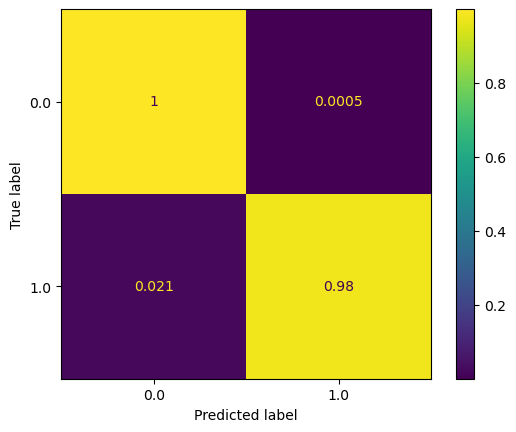

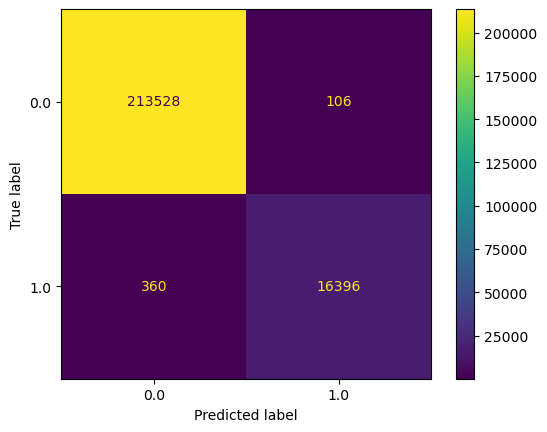

In [5]:

rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision: %f, Recall: %f" % (precision, recall))

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

## ROC and probability.
Receiver operator curve would be good to see as well.
Then we could also get an idea of confidence

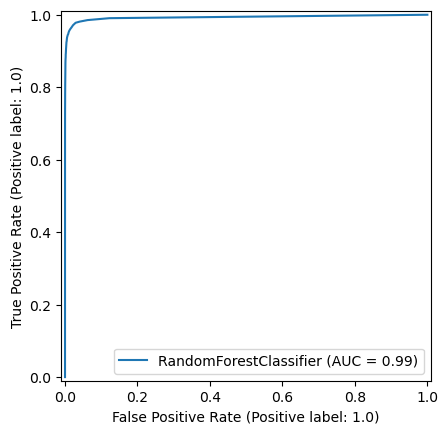

In [6]:
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
from sklearn.metrics import roc_auc_score


In [7]:
#Get probabilities
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X)
y_test_prob = rf.predict_proba(X_test)
roc_auc_score(y_test, y_test_prob[:,1])

0.9930076415052733

In [8]:
#Record the results in the TCEs for the entire data set.
y_all = rf.predict(X)
y_prob = rf.predict_proba(X)

tces['newRF'] = y_all
tces['newRFprob'] = y_prob[:,1]  #Probability it is class "transit"

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

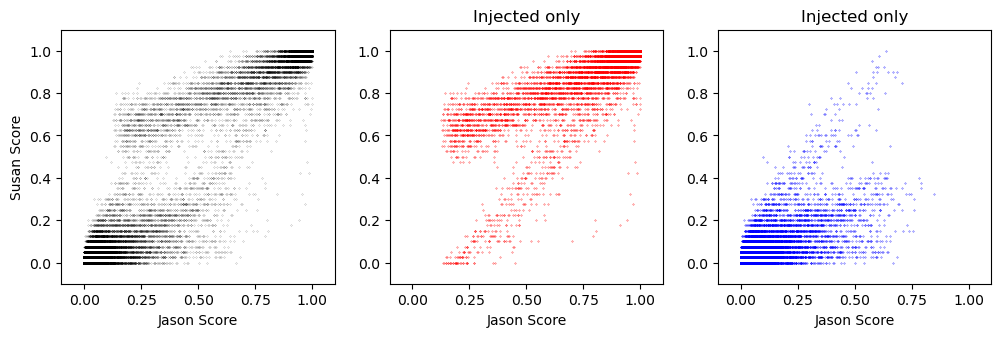

In [9]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')
plt.tight_layout

In [10]:
## What sort of features are most important
isort = np.argsort(rf.feature_importances_)
for i,m in enumerate(metrics):
    print(m, 100*rf.feature_importances_[i])

period 4.709324752655853
power 2.116824185171393
dur 2.5404763669272614
depth 4.216983566512947
snr 11.554727862190468
chisq 5.335911762154303
bicft 12.98200736649893
bicplus 3.701668440316209
bicminus 4.768784809262592
snrshape 11.005706220299308
noise 0.9942535330102396
depth_shape2 17.722171075234655
depth_shape3 12.78503139652966
mindBIC 3.8096707555187628
nloops 1.7564579077174205


Experiment one wihtout snr, but did include Tmag and period

- period 4.746216127437052
- power 2.2961467284076784
- dur 2.1510919825473596
- depth 5.371515043072943
- chisq 5.788101490453752
- bicft 5.067104104626756
- bicplus 4.655442903697127
- bicminus 5.84774230126609
- snrshape 15.156198315686112
- noise 1.0851621139856082
- depth_shape2 17.508743172274595
- depth_shape3 22.97285133104744
- mindBIC 4.516889640310693
- nloops 1.8338846617075462
- Tmag 1.002910083479242

Cross Validation Score mean: 0.989347
Accuracy: 0.989423730775352
Precision: 0.964139, Recall: 0.887629

Experiment 2, now with snr and remove the Tmag, but also include other tests.

period 4.564388433653269
power 0.8999816361535008
dur 2.0308096120763803
depth 3.785738331410811
snr 18.969118189861494
chisq 4.954119743585935
bicft 5.136857849169058
bicplus 4.242946714327086
bicminus 1.936305990383865
snrshape 9.122158065149591
noise 0.7947163623875746
depth_shape2 11.697234977393363
depth_shape3 22.09457923074714
mindBIC 3.4094274774042996
nloops 1.300840469510419
npoints 1.620893135861288
nintransit 3.4398837809249225

Cross Validation Score mean: 0.990005
Accuracy: 0.990364165111333
Precision: 0.962131, Recall: 0.901925


Third experiment now without snr but no npoints and nintransit. Really seem to need snr.

period 4.499735650652979
power 0.8350874916278969
dur 1.8492118440926484
depth 5.304726605545882
deptest1 6.940035709477042
deptest2 3.19386595512975
chisq 5.569434131757326
bicft 7.447460710079981
bicplus 1.0649485483684031
bicminus 2.8008523502347082
snrshape 13.406101176755964
noise 0.8310787054804712
depth_shape2 17.921710301468725
depth_shape3 22.804640108959596
mindBIC 3.9378306937358185
nloops 1.5932800166328125


Cross Validation Score mean: 0.990160
Accuracy: 0.9896986269658695
Precision: 0.964457, Recall: 0.889582

Experiment 4. Here we doing the same as Kelsey and Jason, but adding in period.

period 4.709324752655853
power 2.116824185171393
dur 2.5404763669272614
depth 4.216983566512947
snr 11.554727862190468
chisq 5.335911762154303
bicft 12.98200736649893
bicplus 3.701668440316209
bicminus 4.768784809262592
snrshape 11.005706220299308
noise 0.9942535330102396
depth_shape2 17.722171075234655
depth_shape3 12.78503139652966
mindBIC 3.8096707555187628
nloops 1.756

Cross Validation Score mean: 0.989605
Accuracy: 0.990299058118842
Precision: 0.966371, Recall: 0.899321

The conclusion is that none of this matters a whole lot in the final statistics.
